# Autoencoder
> Creando autoencoders con Keras

- toc: true 
- badges: true
- comments: true
- categories: [practica]
- image: images/chart-preview.png

En este notebook se muestra cómo se puede definir un variational autoencoder. Para ello vamos a utilizar la librería [Keras](https://keras.io) y el dataset MNIST. Pero vamos a ver primero un autoencoder básico.

En esta práctica vamos a hacer un uso intensivo de la GPU, así que es importante activar su uso desde la opción Configuración del cuaderno del menú Editar (esta opción debería estar habilitada por defecto, pero es recomendable que lo compruebes).

## Un autoencoder básico

El dataset [MNIST](http://yann.lecun.com/exdb/mnist/) es un dataset ampliamente utilizado para probar algoritmos de aprendizaje automático. El problema que se intenta resolver con el dataset MNIST consiste en clasificar imágenes en escala de grises de dígitos manuscritos (de tamaño 28x28) en 10 categorías (del 0 al 9). En nuestro caso no vamos a crear un clasificador para el dataset de MNIST sino que lo vamos a utilizar para mostrar cómo podemos usar un auto-encoder para eliminar el ruido de las imágenes. 

Comenzamos cargando las librerías necesarias. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

### Dataset

Para entrenar el autoencoder vamos a usar el dataset de MNIST donde los píxeles estarán normalizados entre 0 y 1. 

En este caso no nos interesan las etiquetas del dataset, solo las imágenes.

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


Normalizamos el dataset y lo preparamos para poder alimentar al autoencoder.

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

### Autoencoder

Pasamos ahora a definir la arquitectura de nuestro autoencoder. Para ello lo primero que debemos hacer es definir la forma que tendrán los datos de entrada de nuestro autoencoder. El dataset MNIST consta de imágenes de tamaño $28\times 28$ en escala de grises, por lo que solo tienen un canal.

In [4]:
input_img = layers.Input(shape=(28,28,1))

Recordar que un autoencoder consta de un encoder y un decoder. Definimos a continuación nuestro encoder que va a constar de una pila de capas de convolución y de max pooling. Al aplicar el proceso de encoding llegamos a una reprentación final de tamaño (4,4,8) es decir 128 dimensiones, es decir hemos reducido casi a una sexta parte la codificación de nuestras imágenes.

In [5]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

El decoder se define mediante una pila de capas de convolución y de upsampling (capas con la función inversa que las de pooling). Notar que la entrada de la primera capa del decoder es la salida del encoder. Notar que la arquitectura es simétrica a la del encoder. 

In [6]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

Por último definimos nuestro modelo de autoencoder y lo compilamos. En Keras es necesario compilar un modelo para fijar el optimizador que se utilizará para entrenarlo (en este caso [ADAM](https://arxiv.org/abs/1412.6980) que es una variante del descenso de gradiente) y la función de pérdida (en este caso la [binary crossentropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class)).

In [7]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Con la siguiente instrucción podemos mostrar la arquitectura de una red de Keras. 

In [8]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

También puede ser útil visualizar dicha red.

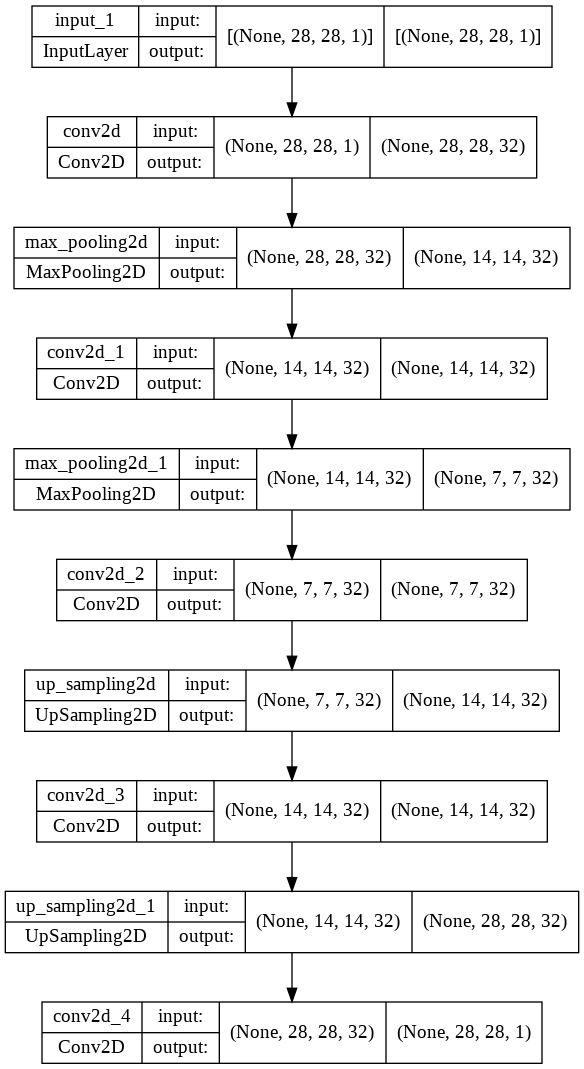

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='autoencoder_plot.png', show_shapes=True, show_layer_names=True)

Vamos ahora a entrenar nuestro modelo para ello usamos el método `fit` que está disponible para cualquier modelo de Keras.

In [10]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 [==============================] - 19s 18ms/step - loss: 0.1155 - val_loss: 0.0767
Epoch 2/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0742 - val_loss: 0.0715
Epoch 3/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0712 - val_loss: 0.0700
Epoch 4/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0697 - val_loss: 0.0686
Epoch 5/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0688 - val_loss: 0.0679
Epoch 6/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0680 - val_loss: 0.0673
Epoch 7/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0675 - val_loss: 0.0667
Epoch 8/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0669 - val_loss: 0.0663
Epoch 9/50
469/469 [==============================] - 7s 15ms/step - loss: 0.0666 - val_loss: 0.0662
Epoch 10/50
469/469 [==============================] - 7s 14ms/step - loss: 0.0662 - val_l

Vamos a mostrar la reconstrucción de algunos de los dígitos. Al ejecutar la siguiente celda, la primera fila muestra los dígitos originales y la segunda los reconstruidos. 

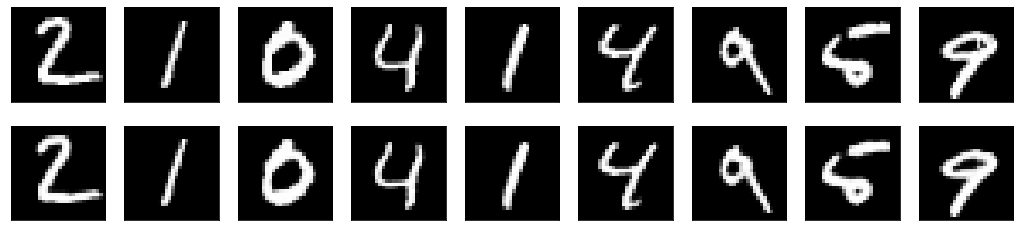

In [11]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Aplicación a la eliminación de ruido

Vamos a poner ahora a nuestro encoder a trabajar en el problema de la eliminación de ruido. Esto va a ser tan sencillo como entrenar nuestro autoencoder para mapear dígitos con ruido a imágenes limpias.

Para ello, el primer paso es construir nuestro dataset con ruido aplicando un ruido Gaussiano a las imágenes, y luego limitando los valores al rango de 0 a 1.

En primer lugar procedemos a añadir ruido a las imágenes del dataset de MNIST.

In [12]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Podemos ver a continuación algunas de las imágenes a las que se les ha añadido el ruido.

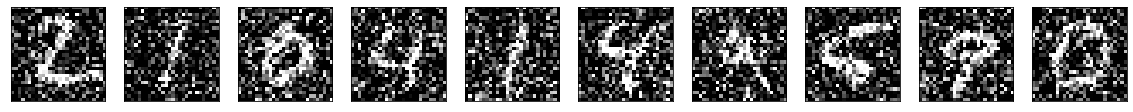

In [13]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Autoencoder

Pasamos ahora a definir la arquitectura de nuestro autoencoder. Para ello lo primero que debemos hacer es definir la forma que tendrán los datos de entrada de nuestro autoencoder. El dataset MNIST consta de imágenes de tamaño $28\times 28$ en escala de grises, por lo que solo tienen un canal.

In [14]:
input_img = layers.Input(shape=(28,28,1))

Recordar que un autoencoder consta de un encoder y un decoder. Definimos a continuación nuestro encoder que va a constar de una pila de capas de convolución y de maxpooling.

In [15]:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

El decoder se define mediante una pila de capas de convolución y de upsampling (capas con la función inversa que las de pooling). Notar que la entrada de la primera capa del decoder es la salida del encoder; además, al igual que antes la arquitectura es simétrica al encoder. 

In [16]:
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

Por último definimos nuestro modelo de autoencoder y lo compilamos.

In [17]:
autoencoder_noise = keras.Model(input_img, decoded)
autoencoder_noise.compile(optimizer='adam', loss='binary_crossentropy')

Con la siguiente instrucción podemos mostrar la arquitectura del nuevo autoencoder. 

In [18]:
autoencoder_noise.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248

También puede ser útil visualizar dicha red.

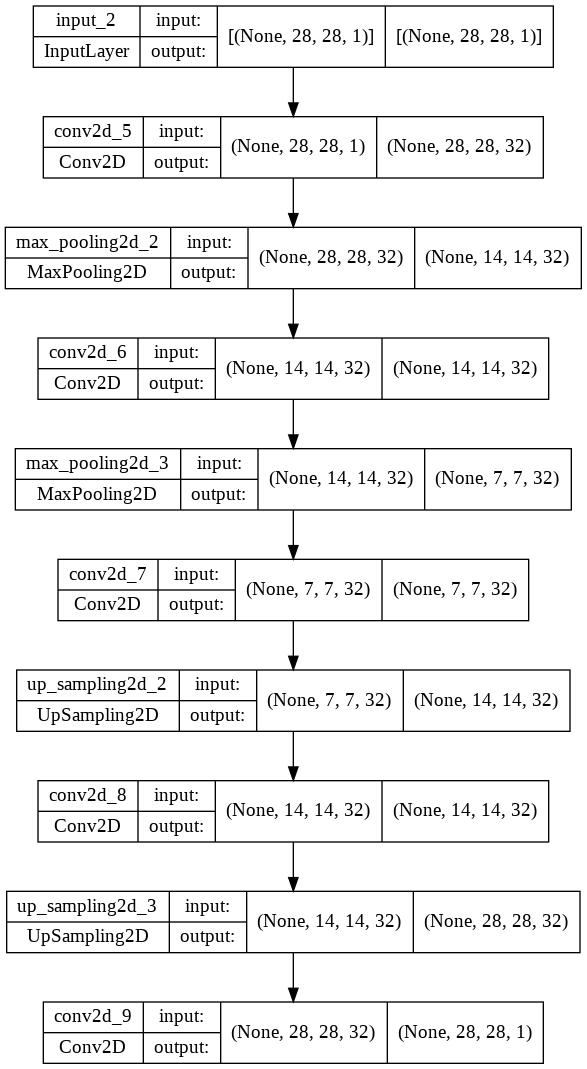

In [19]:
plot_model(autoencoder_noise, to_file='autoencoder_noise_plot.png', show_shapes=True, show_layer_names=True)

Vamos ahora a entrenar nuestro modelo para ello usamos el método `fit` que está disponible para cualquier modelo de Keras.

In [20]:
autoencoder_noise.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

Epoch 1/100
469/469 [==============================] - 8s 15ms/step - loss: 0.1726 - val_loss: 0.1164
Epoch 2/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1134 - val_loss: 0.1092
Epoch 3/100
469/469 [==============================] - 6s 14ms/step - loss: 0.1083 - val_loss: 0.1059
Epoch 4/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1056 - val_loss: 0.1041
Epoch 5/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1037 - val_loss: 0.1021
Epoch 6/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1023 - val_loss: 0.1009
Epoch 7/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1011 - val_loss: 0.0998
Epoch 8/100
469/469 [==============================] - 7s 14ms/step - loss: 0.1001 - val_loss: 0.0990
Epoch 9/100
469/469 [==============================] - 7s 14ms/step - loss: 0.0993 - val_loss: 0.0982
Epoch 10/100
469/469 [==============================] - 7s 14ms/step - loss: 0.098

Por último podemos predecir usando el modelo entrenado con las imágenes de test:

In [21]:
decoded_imgs = autoencoder_noise.predict(x_test_noisy)

Y a continuación mostrar el resultado obtenido. 

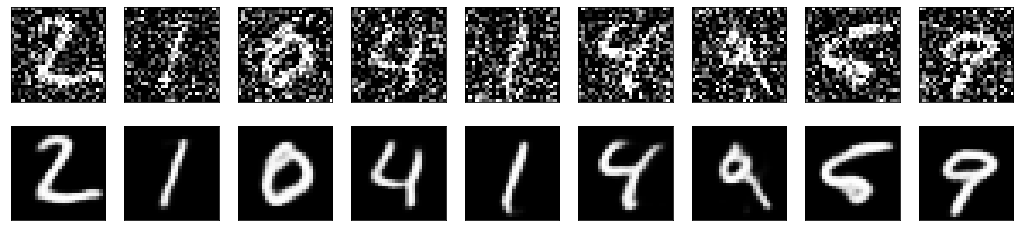

In [22]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational autoencoder

Como hemos visto en teoría un autoencoder toma una imagen, la mapea a un espacio vectorial subyacente por medio de un encoder, y seguidamente la decodifica a una salida con el tamaño de la imagen original. En la práctica, los autoencoders no son especialmente útiles, y han sido reemplazados por los variational autoencoders (o VAEs).

Un VAE en lugar de comprimir la imagen en un vector fijo en el espacio subyacente, la convierte a los parámetros de una distribución estadística (representada mediante una media y una varianza). Esencialmente, esto significa que asumimos que la imagen original ha sido generada mediante un proceso estadístico, y que la aleatoriedad de dicho proceso debe ser tomada en cuenta a la hora de proceso de codificación y decodificación. 

Un VAE usa los parámetros de media y varianza para tomar una muestra aleatoria de un elemento de la distribución, y decodifica dicho elemento de vuelta. Esto hace que mejore la robusted y fuerza a que el espacio subyacente obtenga representaciones significativas (notar que cualquier muestra de la distribución tiene que ser decodificada a una salida valida).

Desde el punto de vista técnico, un VAE funciona del siguiente modo:
1. Un encoder convierte la entrada en dos parámetros de un espacio subyacente de representaciones que denotaremos por `z_mean` y `z_log_var`.
2. Tomamos una muestra aleatoria `z` de la distribución normal que asumimos que genera la imagen de entrada mediante la fórmula `z = z_mean + exp(z_log_var)*epsilon` donde `epsilon` es un valor aleatorio pequeño.
3. La muestra `z` se decodifica.  Al tomar `epsilon` de manera aleatoria y con valor pequeño, el proceso asegura que cada punto que está cerca de la localización subyacente de la imagen puede ser decodificado a algo similar a la imagen de entrada. 

Para entrenar un VAE se usan dos funciones de pérdida: una que es la función de pérdida de reconstrucción que fuerza a que las muestras decodificadas se ajusten a las entradas iniciales, y una función de pérdida de regularización que ayuda a una formación correcta de los espacios subyacentes y a que no se produzca sobreajuste. 

### Capa de Sampling

Lo primero que vamos a definir es una nueva capa encargada de tomar una muestra aleatoria a partir de los valores de `z_mean` y `z_log_var`. Para ello debemos definir una nueva clase que hereda de la clase `Layer` de Keras y definir la función `call`.

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

El encoder va a ser similar al encoder que vimos para el autoencoder, la principal diferencia es que va a producir dos vectores de salida, `z_mean` y `z_log_var`.

In [24]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_10[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_11[0][0]']              
                                                                                            

### Decoder

Ahora podemos definir el decoder, utilizando una arquitectura simétrica al encoder. 

In [25]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

Por último vamos a definir un nuevo modelo que une nuestro encoder y decoder definidos anteriormente, y definimos nuestra función de pérdida que va a tener en cuenta la función de pérdida de reconstrucción y la función de pérdida de regularización. Para ello debemos definir una nueva clase que herede de `Model`.

In [26]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Entrenamiento

Finalmente, instanciamos el modelo y lo compilamos. Notar que no es necesario definir una función de pérdida de manera explícita ya que la hemos definido anteriormente. Esto supone que a la hora de entrenar el modelo no hará falta proporcionar la salida espera del modelo ya que es la misma que la entrada y de ello se encarga la capa definida anteriormente. 

In [27]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Podemos ahora entrenar el modelo para lo que vamos a juntar los conjuntos de entrenamiento y test de MNIST. 

In [28]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 12s 18ms/step - loss: 258.3222 - reconstruction_loss: 207.3263 - kl_loss: 3.3780
Epoch 2/30
547/547 [==============================] - 10s 18ms/step - loss: 175.8255 - reconstruction_loss: 167.4281 - kl_loss: 5.5007
Epoch 3/30
547/547 [==============================] - 10s 18ms/step - loss: 167.3953 - reconstruction_loss: 160.0686 - kl_loss: 5.8272
Epoch 4/30
547/547 [==============================] - 10s 18ms/step - loss: 162.9637 - reconstruction_loss: 155.8265 - kl_loss: 6.1042
Epoch 5/30
547/547 [==============================] - 10s 18ms/step - loss: 159.7077 - reconstruction_loss: 153.3320 - kl_loss: 6.2538
Epoch 6/30
547/547 [==============================] - 10s 18ms/step - loss: 158.1543 - reconstruction_loss: 151.6510 - kl_loss: 6.3135
Epoch 7/30
547/547 [==============================] - 10s 18ms/step - loss: 156.9544 - reconstruction_loss: 150.2694 - kl_loss: 6.3696
Epoch 8/30
547/547 [==============================] - 1

Una vez que el modelo se ha entrenado, podemos usar el decoder para convertir puntos aleatorios del espacio subyacente en imágenes. 

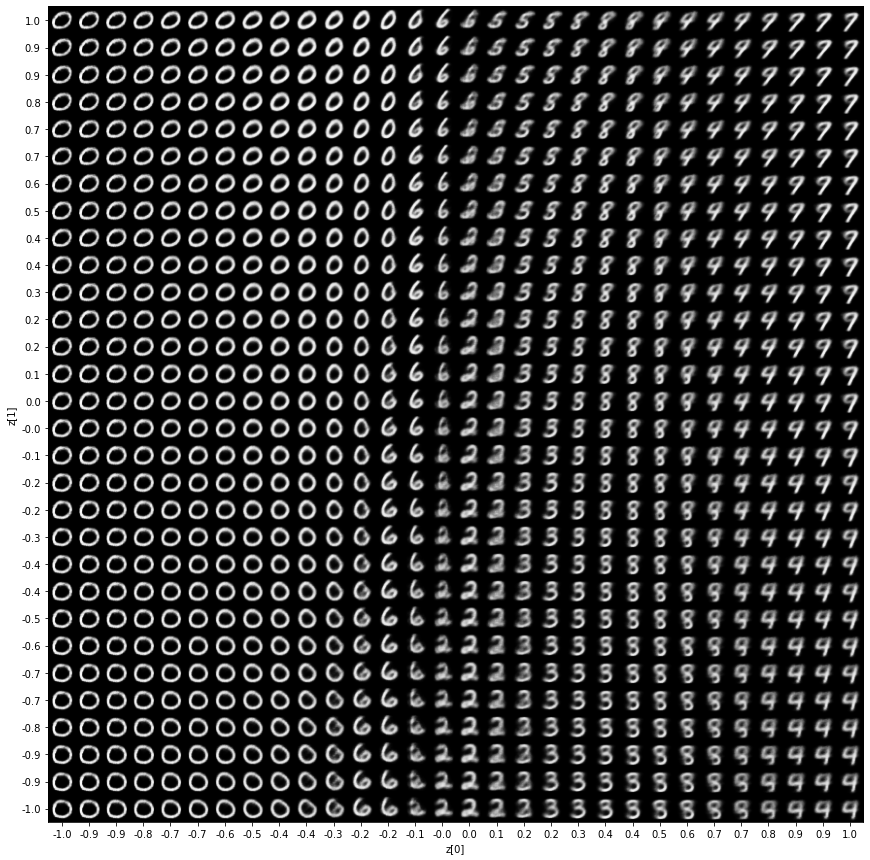

In [29]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

La cuadrícula anterior muestra una distribución continua de los dígitos de las distintas clases, y se puede ver cómo un dígito se transforma en otro al seguir un camino a través del espacio subyacente. Notar que hay direcciones subyacentes que tienen significado (como cuatri-ficar o uni-ficar).

Por último podemos ver los clústeres del espacio subyacente asociados a cada clase. 

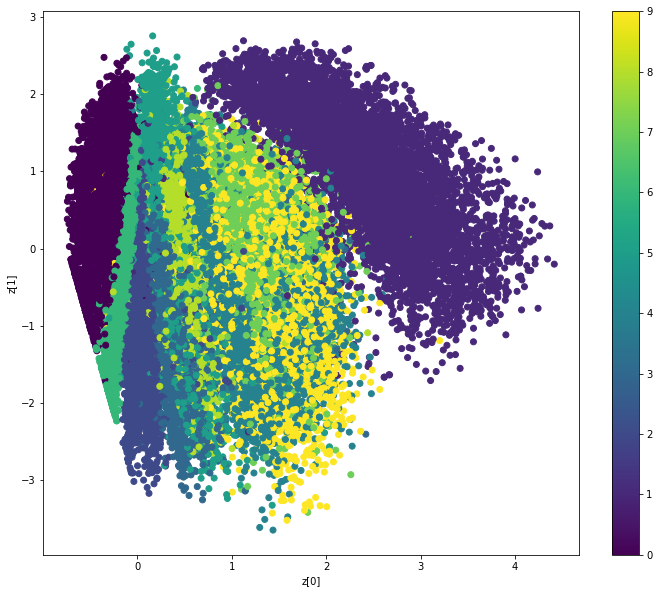

In [30]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.set_cmap('viridis')
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)